In [225]:
import pandas as pd

In [226]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data'

/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data


In [4]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Графики всех временных рядов

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

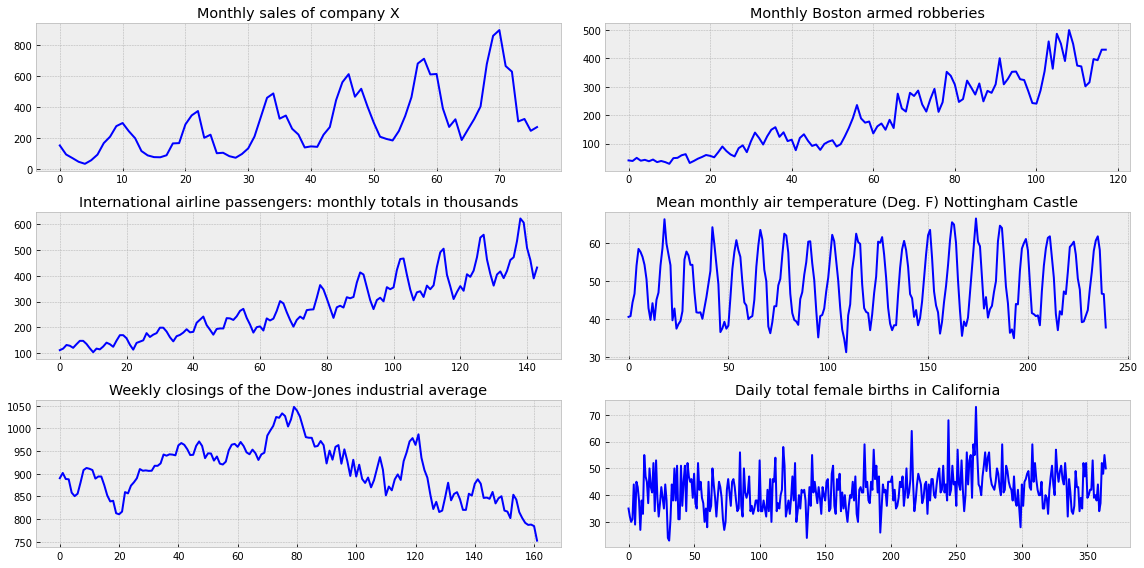

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# 1. Monthly sales of company X

**По графику видно, что присутствуют сезонность и тренд. Также заметно, что дисперсия постепенно увеличивается.**

### Нормализуем дисперсию

In [135]:
from scipy.stats import boxcox

In [136]:
series = boxcox(sales_of_company_x["Count"], 0)

### Определим и устраним сезонность

In [137]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

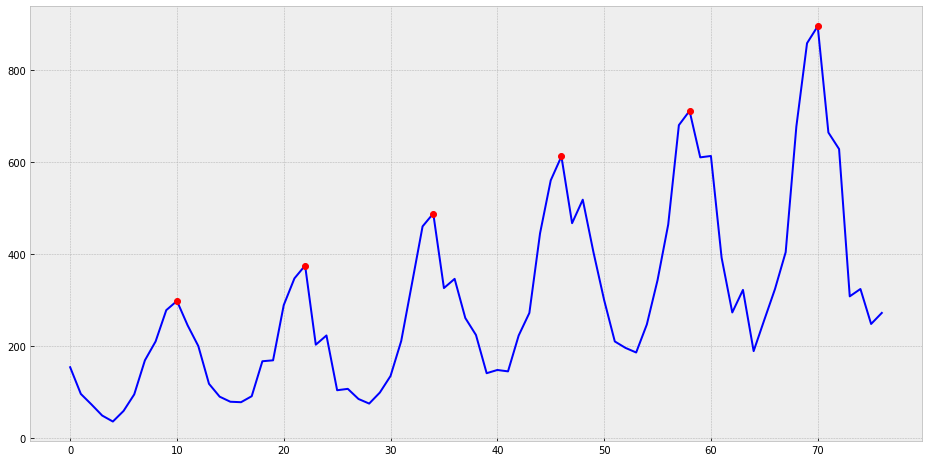

In [138]:
plot_ts_and_points(sales_of_company_x["Count"], 10, 12)

Сезонность = 12 (месяцам). Значит ее можно устранить, продифференцировав ряд со сдвигом на 12.

In [139]:
import numpy as np

In [140]:
series = np.diff(series, 12)

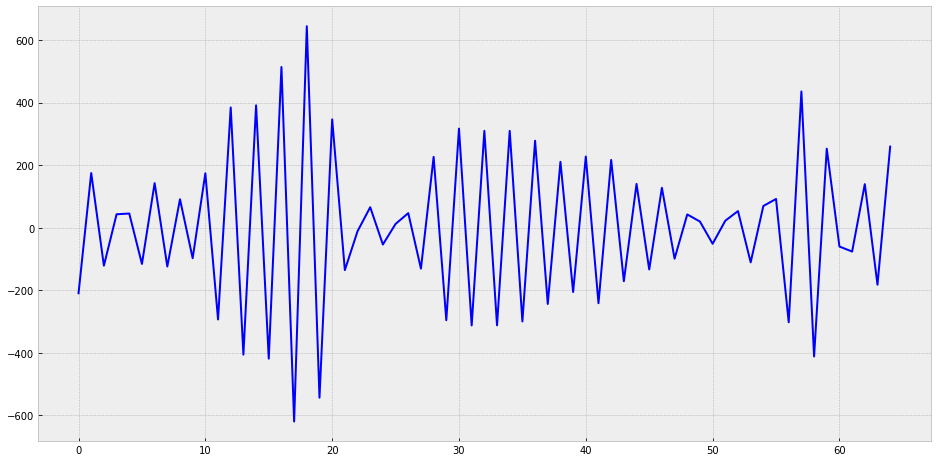

In [142]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

### Проверим, стал ли наш ряд стационарным

In [143]:
from statsmodels.tsa.stattools import adfuller

In [144]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [145]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.633549e+00
p-value                        1.979614e-11
#Lags Used                     1.100000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


In [146]:
test_stationarity(sales_of_company_x["Count"])

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [147]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [148]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


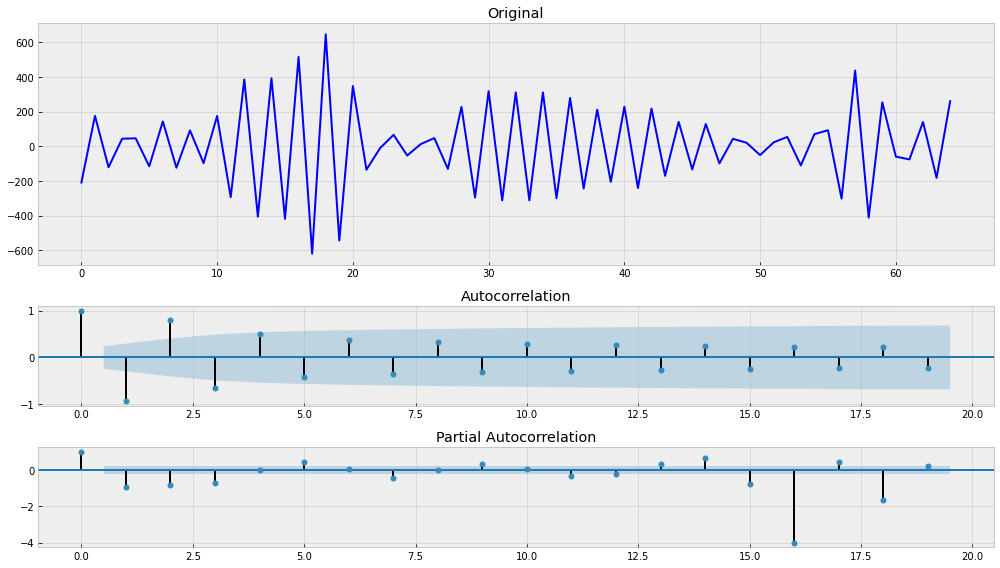

In [149]:
tsplot(series)

**Выводы:** мы сделали ряд стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: автокорреляция быстро убывает с увеличением лага.

# 2. Monthly Boston armed robberies

**На графике заметен тренд и увеличение дисперсии со временем.**

### Нормализуем дисперсию

In [153]:
series = boxcox(robberies_in_boston["Count"], 0)

### Устраним тренд

In [154]:
series = np.diff(series, 1)

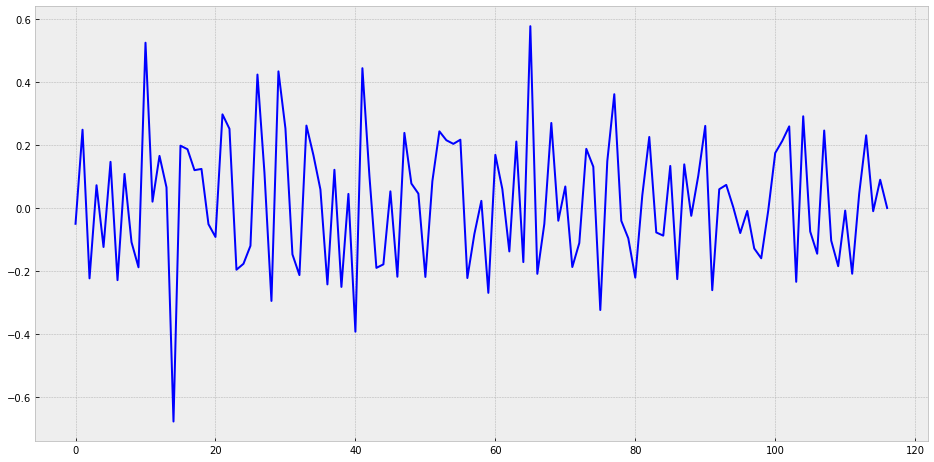

In [155]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

### Проверим, стал ли наш ряд стационарным

In [156]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


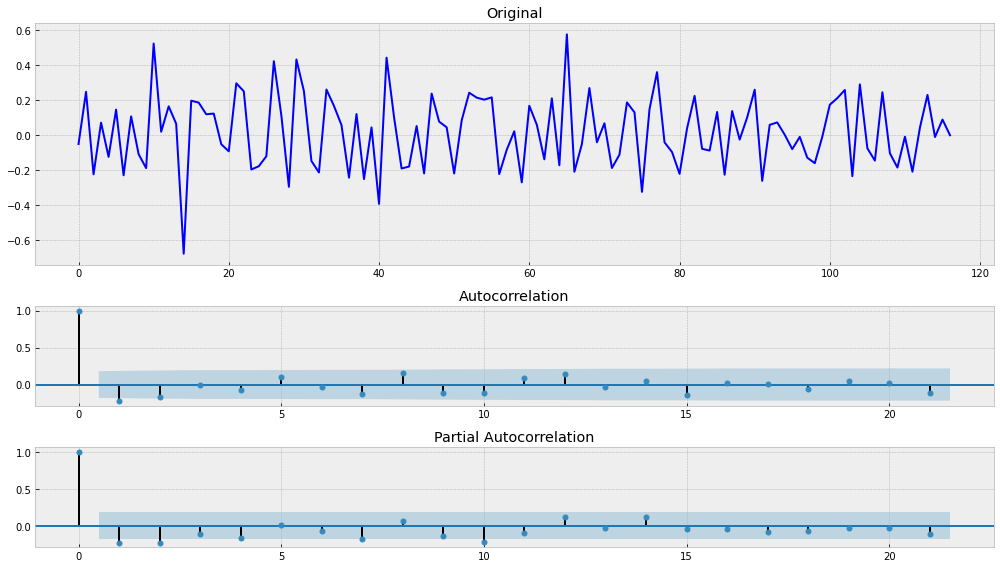

In [157]:
tsplot(series)

**Выводы:** мы сделали ряд стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: автокорреляция быстро убывает с увеличением лага.

# 3. International airline passengers: monthly totals in thousands

**По графику видно, что присутствуют сезонность и тренд. Также заметно, что дисперсия постепенно увеличивается.**

### Нормализуем дисперсию

In [214]:
series = boxcox(airlines_passengers["Count"], 0)

### Определим и устраним сезонность

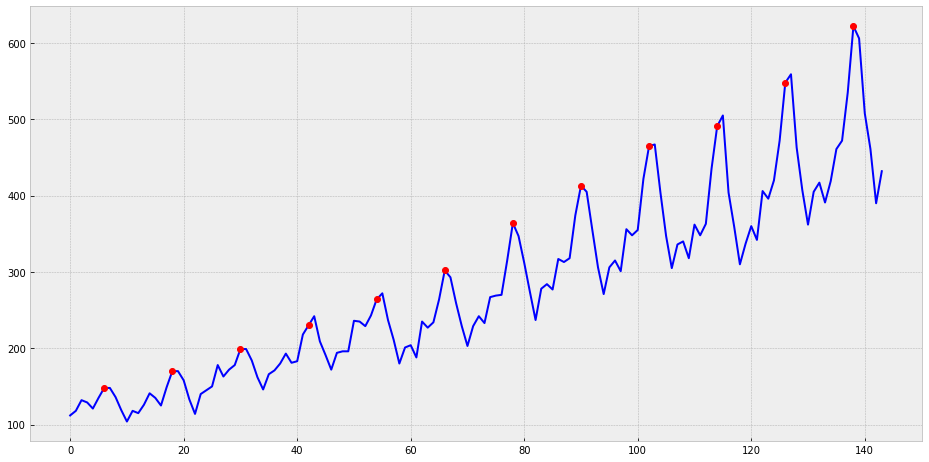

In [220]:
plot_ts_and_points(airlines_passengers["Count"], 6, 12)

Сезонность = 12 (месяцам). Значит ее можно устранить, продифференцировав ряд со сдвигом на 12.

In [221]:
series = np.diff(series, 12)

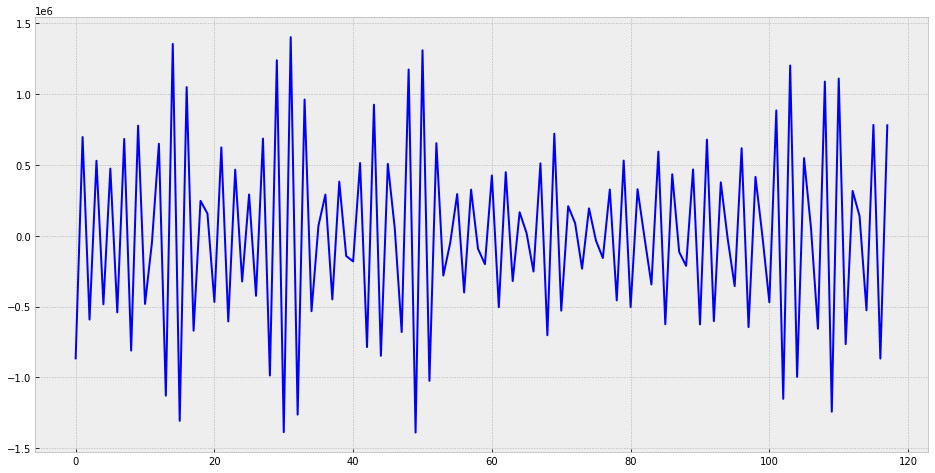

In [222]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

### Проверим, стал ли наш ряд стационарным

In [223]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                 -22.209661
p-value                          0.000000
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


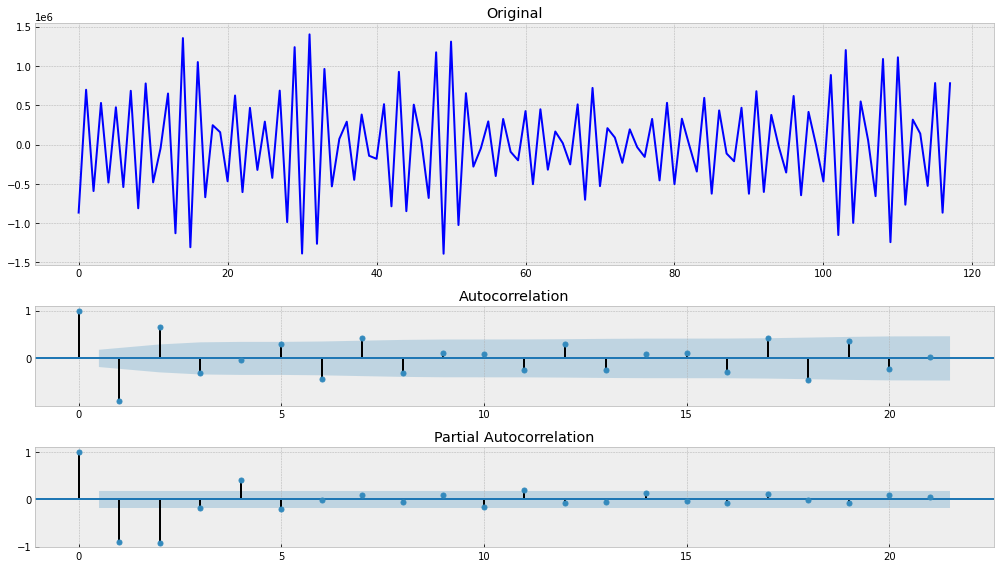

In [224]:
tsplot(series)

**Выводы:** мы сделали ряд стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: график быстро убывает после первых 3-х значений и большинство коэффициентов корреляции статистически незначимы.

# 4. Mean monthly air temperature (Deg. F) Nottingham Castle

**По графику видно, что присутствует сезонность. Дисперсия не имеет тенденции к значительному изменению.**

### Определим и устраним сезонность

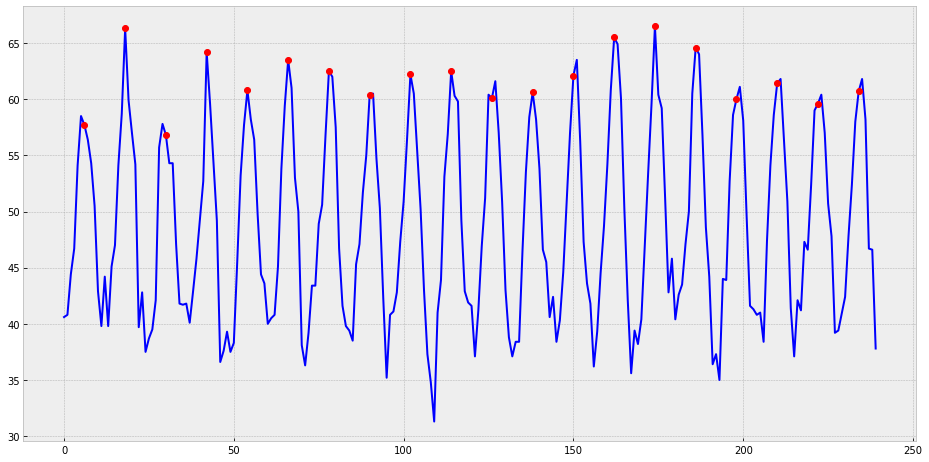

In [256]:
plot_ts_and_points(mean_monthly_temp["Deg"], 6, 12)

Сезонность = 12 (месяцам). Значит ее можно устранить, продифференцировав ряд со сдвигом на 12.

In [250]:
series = boxcox(mean_monthly_temp["Deg"], 0)

In [257]:
series = mean_monthly_temp["Deg"]

In [258]:
series = np.diff(series, 12)

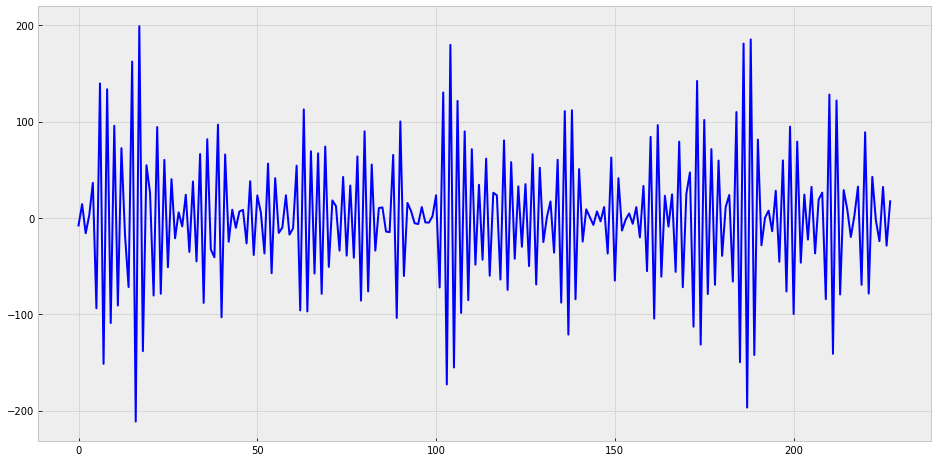

In [252]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

### Проверим, стал ли наш ряд стационарным

In [259]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.672894e+01
p-value                        1.388342e-29
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


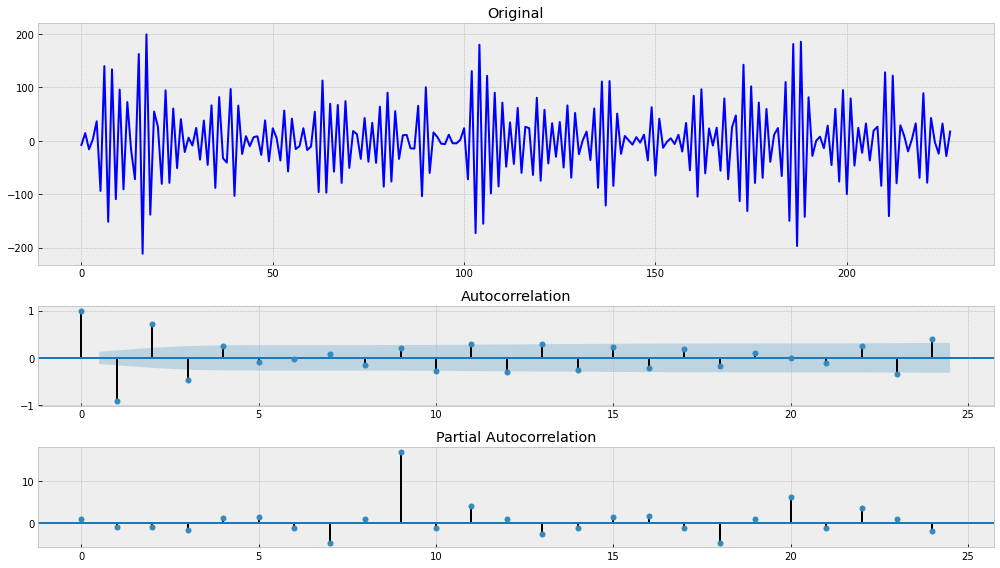

In [254]:
tsplot(series)

**Выводы:** мы сделали ряд стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: график быстро убывает после первых 4-х значений и коэффициенты корреляции статистически незначимы.

# 5. Weekly closings of the Dow-Jones industrial average

**По графику видно, что присутствуют тренды.**

### Избавимся от трендов

In [272]:
series = np.diff(dowjones_closing["Close"], 1)

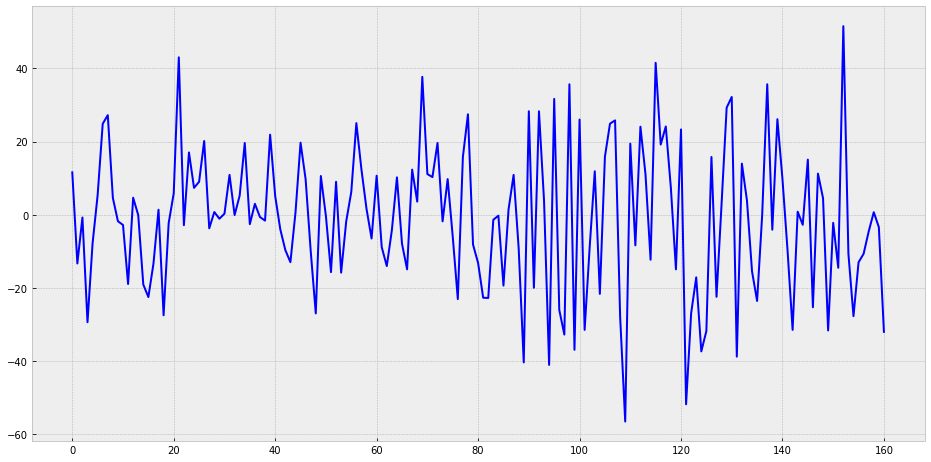

In [273]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

### Проверим, стал ли наш ряд стационарным

In [274]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


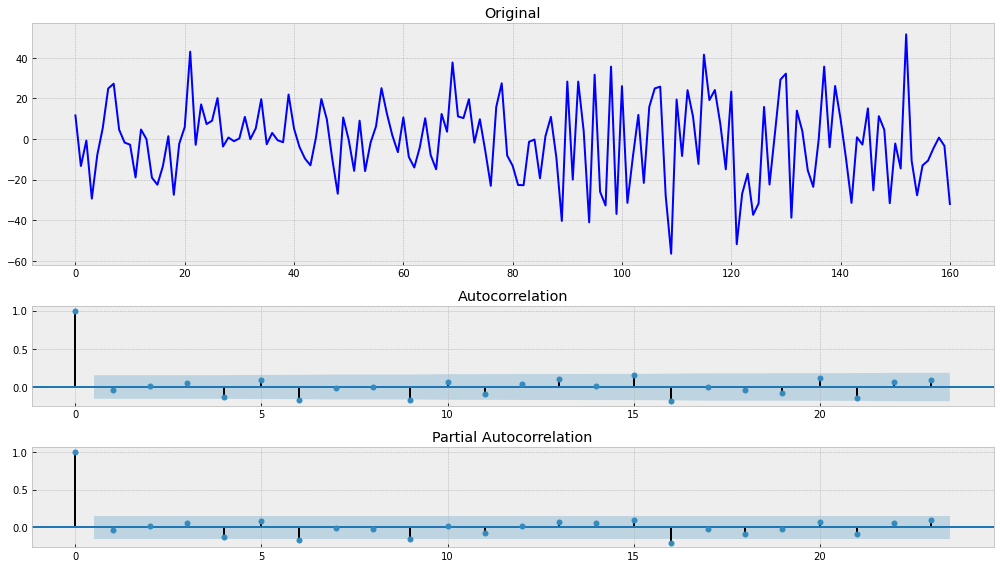

In [275]:
tsplot(series)

**Выводы:** мы сделали ряд стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: график быстро убывает уже после первого значения и коэффициенты корреляции статистически незначимы.

# 6. Daily total female births in California

**По графику не видно трендов или сезонности. Вероятно, ряд является стационарным.**

In [292]:
series = female_births["Count"]

### Проверим, стал ли наш ряд стационарным

In [293]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


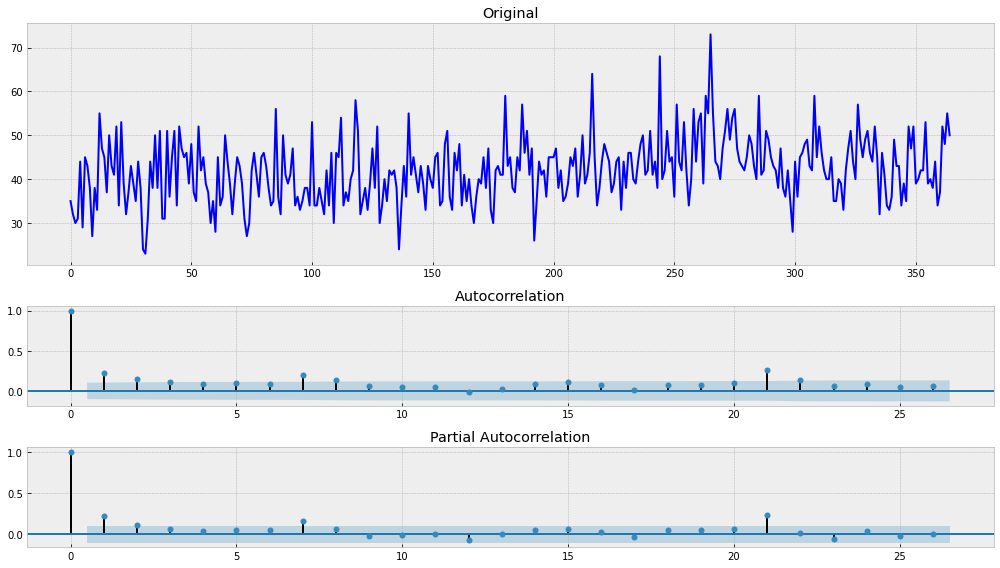

In [294]:
tsplot(series)

**Выводы:** ряд является стационарным, что подтверждается:\
1) значением p-value (< 0.01);\
2) графиком автокорреляции: график быстро убывает уже после первого значения и коэффициенты корреляции статистически незначимы.